In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

__3 more clustering methods__
1. Mean-shift
2. Spectral clustering
3. Affinity propagation

[More sklearn clustering methods](http://scikit-learn.org/stable/modules/clustering.html)

__Note:__ dataset here is simulated and does not need to be normalized, but real data must be normalized to ensure features are given equal weight in finding a clustering solution

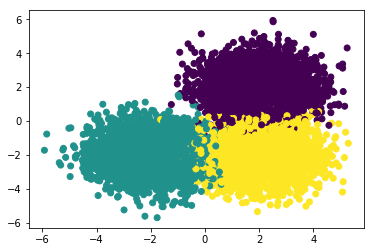

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

#coordinates of blob centers
centers = [[2,2], [-2,-2], [2,-2]]

#make 10,000 rows of data, 2 features representing 3 clusters, each std=1
X, y = make_blobs(n_samples=10000,
                  centers=centers,
                  cluster_std=1,
                  n_features=2,
                  random_state=42)

plt.scatter(X[:, 0], X[:,1], c=y)
plt.show()

#set train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)

## Mean-shift
Works by calculating the probability that a data point will be present at any point in the n-dimensional space where n is defined by the number of features
- __Kernel density surface:__ surface of probabilities
- Visualize kernel density surface as having 'hills'
    - Hills peak where many datapoints are present
    - Valleys where few datapoints are present
    - Peaks represent cluster means
- Iterative algorithm
    - With each iteration, all datapoints are shifted up the nearest hill by a small amount
    - Datapoints that are already at peak stay put
    - Stops once all datapoints have reached peaks and subsequent shifts are smaller than a given threshold
    - Clusters are determined by datapoints' peaks
- __Bandwidth parameter:__ sets how high hills have to be to qualify as a peak
    - User defined, ranges 0-1
    - Higher bandwidth: smoother kernel density surface, fewer peaks (small hills are smoothed out)
    - Lower bandwidth: surface with more peaks, contains same peaks reached by higher bandwidth with additional lower peaks

- More versatile than k-means
    - Mean-shift makes no assumptions about the nature of the data or the number of clusters
- Works well on datasets where many clusters are suspected
- Unlike k-means, clusters...
    - Do not have to be same size
    - Can have non-flat geometry
        - Clusters based on _m_ features cannot be separated by a straight line or plane in the _m_-dimensional space
- Recommended for sm - med sized datasets
    - Slow runtime which increases with the square of the size of the input
- Datapoints that are very far from peaks can potentially not be assigned to any cluster
    - Depends on termination threshold and number of iterations allowed
    - k-means and other clustering methods learned here assign all data points to clusters, even if they are very poorly suited to clustering

[Mean-shift clustering animations](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/)

#### Mean-shift code:

In [3]:
from sklearn.cluster import MeanShift, estimate_bandwidth

#estimate_bandwidth function automatically derives bandwidth by inspecting
#distances of datapoints in dataset
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

#declare fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_train)

#extract cluster assignments
labels = ms.labels_

#coordinates of cluster centers
cluster_centers = ms.cluster_centers_

#count clusters
n_clusters_ = len(np.unique(labels))

print('number of estimated clusters: {}'.format(n_clusters_))

number of estimated clusters: 3


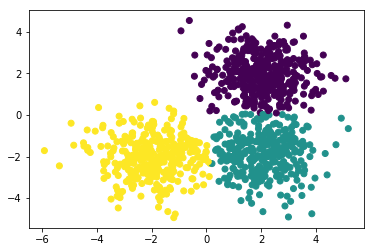

comparing assigned categories to the ones in the data
col_0    0    1    2
row_0               
0      352   10    0
1        1    8  311
2        6  304    8


In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('comparing assigned categories to the ones in the data')
print(pd.crosstab(y_train, labels))

## Spectral clustering
Quantifies similarity between data points by defining a similarity matrix of _n x n_ dimensions where _n =_ number of datapoints in the dataset
- Defines a matrix of indices of similarity for each pairwise combination of datapoints
- Then applies a transformation matrix to calculate a set of eigenvectors with appropriate eigenvalues
    - PCA on a similarity matrix rather than a covariance matrix

Measuring affinity (similarity): can provide any kernel function that computes pairwise similarity where _0 =_ no similarity, and higher numbers indicate greater similarity
- Two common methods:
    - Nearest neighbors
    - Radial basis function (rbf): gaussian kernel of the euclidean distance
- _k =_ number of clusters desired, user provided
    - *k* eigenvectors with the *k* largest eigenvalues are extracted and data is converted to a new *k*-dimensional space
    - *k*-means algorithm is applied to new *k*-dimensional data to extract *k* clusters
- Slow and works best when *k* is not too large & cluster sizes are equal
- Dimensional reduction aspect means algorithm can identify clusters with non-flat geometry
- Clusters not necessarily globular in original dimensional space

#### Spectral clustering code

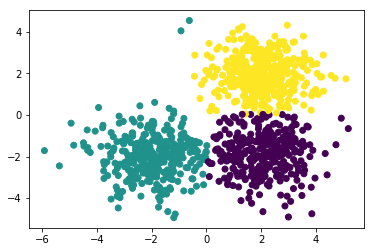

compare assigned categories to ones in the data
col_0    0    1    2
row_0               
0       10    2  350
1        9  310    1
2      305    6    7


In [5]:
from sklearn.cluster import SpectralClustering

#k is known, fit model and predict clusters
sc = SpectralClustering(n_clusters=3).fit(X_train)
predict = sc.fit_predict(X_train)

#plot results
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('compare assigned categories to ones in the data')
print(pd.crosstab(y_train, predict))

__Results:__ similar to mean-shift, note 2 dots at top changed cluster

## Affinity propagation
Defines exemplars for datapoints
- **Exemplar:** a datapoint similar enough to another datapoint that they could represent each other
    - Conveys largely the same information
- Chooses number of clusters based on the data
    - Tends to select more clusters than other methods
    - Better suited when many clusters are suspected
- Clusters can be uneven in size and/or geometrically non-flat

Starts with *n x n* similarity matrix
- Any similarity computation can be used
- Similarity between points *l* and *m* is interpreted to mean how well-suited *l* is to be an exemplar of *m* (and vice versa)
    - Very similar datapoints make good exemplars for one another

There is an additional clustering matrix *c* that is also *n x n*
- Matrix entry $c_{lm} = 1$ if *m* is the exemplar of *l*, otherwise $c_{lm} = 0$
- Entry $c_{mm} = 1$ if *m* is an exemplar, otherwise $c_{mm} = 0$
- Algorithm tries to find matrix composition for *c* that maximizes net similarity
    - Net similarity is measured as the sum of all values of *c* multiplied by its corresponding value for *s*:
$$\sum_{l=1}^{n}\sum_{m=1}^{n}c_{lm}s(l,m)$$
- Maximized by juggling two parameters:
    1. __Availability__ parameter: sent from candidate exemplars to potential cluster members to quantify how well-suited that point is to be an exemplar
    2. __Responsibility__ parameter: sent from cluster members to exemplars to quantify how well-suited the point is to be a member of that exemplar's cluster
- Sum-product algorithm (or loopy belief propagation)
    - Iteration procedure:
        1. Uses current availability information to update the responsibility information
        2. Then uses new responsibility information to update availability information
        3. Then calculates net similarity score for *c* matrix based on the updated availability and responsibility information
    - Affinity propagation tuning parameters:
        1. __Damping:__ causes responsibility and availability calculations to be weighted by the previous responsibility and availability options, slows changes to help avoid calculations overshooting optimal solution
        2. __Preference:__ user can specify points (corresponding to *s(l,l)* that should be more likely to be chosen as exemplars; if no values are provided all preference values are set to the median of similarity values for all datapoint pairs
- CPU and memory intensive
    - Time to run each iteration and memory demand increases with the square of the input data
    - Works best on sm - med datasets or on powerful machines

[More on affinity propagation](http://www.psi.toronto.edu/affinitypropagation/faq.html)

#### Affinity propagation code:

In [6]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import time

#declare/fit
start_time = time.clock()
af = AffinityPropagation().fit(X_train)
print('runtime: {} seconds'.format(time.clock() - start_time))

#extract n_clusters and cluster assignments
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('estimated n_clusters: {}'.format(n_clusters_))

runtime: 3.7327310000000002 seconds
estimated n_clusters: 93


__Result:__ High number of clusters, affinity propagation tends to overestimate n_clusters

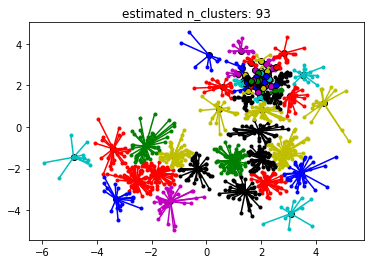

In [7]:
from itertools import cycle

plt.figure(1)
plt.clf()

#cycle through clusters and plot them
#center point = exemplar
#lines = distance between exemplar and its datapoints
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(
        X_train[class_members, 0],
        X_train[class_members, 1],
        col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]],
                 [cluster_center[1], x[1]],
                 col)

plt.title('estimated n_clusters: {}'.format(n_clusters_))
plt.show()

## Drill:
You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configuations, then run the four methods ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 